In [ ]:
# %env SUMO_HOME="/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/share/sumo"
# %env LIBSUMO_AS_TRACI=1
# %env PATH=$PATH:/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/share/sumo/bin


env: SUMO_HOME="/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/share/sumo"
env: LIBSUMO_AS_TRACI=1
env: PATH=$PATH:/Library/Frameworks/EclipseSUMO.framework/Versions/1.22.0/EclipseSUMO/share/sumo/bin


In [2]:
import torch
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from copy import deepcopy
import matplotlib.pyplot as plt
import torch.nn as nn
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import os
import sys
import matplotlib.pyplot as plt

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")

from env import SumoEnvironment
from sumo_rl.agents import QLAgent
from sumo_rl.exploration import EpsilonGreedy

from custom_observation import CustomEmergencyObservationFunction
from custom_reward import emergency_reward_fn

/Users/atharva/Documents/CSE/RL/rl-final/ve/lib/python3.9/site-packages/traci/__init__.py:41: UserWarning: Could not import libsumo, falling back to pure python traci (No module named 'libsumo').
  warnings.warn("Could not import libsumo, falling back to pure python traci (%s)." % e)


In [3]:
class DQNetwork(nn.Module):
    def __init__(self, inp_size, op_size):
        super(DQNetwork, self).__init__()
        self.activation = nn.ReLU()
        self.hl1 = nn.Linear(inp_size, 128)
        self.hl2 = nn.Linear(128, 128)
        self.fc = nn.Linear(128, op_size)
        self.init_weights()
    
    def init_weights(self):
        torch.nn.init.xavier_normal_(self.hl1.weight)
        torch.nn.init.xavier_normal_(self.hl2.weight)
        torch.nn.init.xavier_normal_(self.fc.weight)
        torch.nn.init.zeros_(self.hl1.bias)
        torch.nn.init.zeros_(self.hl2.bias)
        torch.nn.init.zeros_(self.fc.bias)
    
    def forward(self, x):
        x = self.hl1(x)
        x = self.activation(x)
        x = self.hl2(x)
        x = self.activation(x)
        x = self.fc(x)
        return x

In [4]:
class GreedyAgent:
    
    def __init__(self, model, env, initial_epsilon, epsilon_decay, final_epsilon, discount_factor, num_episodes=1000):
        self.env = env
        self.model = model
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
    def step(self, obs, train=True):
        if train:
            if np.random.random() < self.epsilon:
                return self.action_space.sample()
            else:
                self.model.eval()
                with torch.no_grad():
                    output = self.model(torch.from_numpy(obs['t']).to(dtype=torch.float32))
                    return torch.argmax(output).item()
        else:
            self.model.eval()
            with torch.no_grad():
                output = self.model(torch.from_numpy(obs['t']).to(dtype=torch.float32))
                return torch.argmax(output).item()
        

    def decay(self):
        self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)

In [5]:
env = SumoEnvironment(
        net_file="single-intersection/single-intersection.net.xml",
        route_file="single-intersection/single-intersection.rou.xml",
        out_csv_name="out_csv",
        use_gui=False,
        num_seconds=500,
        min_green=5,
        max_green=10,
        observation_class = CustomEmergencyObservationFunction,
        reward_fn = emergency_reward_fn
    )

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 0 ACT 0 BUF 0)                      


In [6]:
# training params
BUFFER_SIZE = 500
batch_size = 32
sync_target_step = 300
train_every_step = 1
episodes = 200
replay_buffer = torch.zeros((BUFFER_SIZE, 12 + 1 + 1 + 12 + 1), dtype = torch.float32) #[sx9, a, r, s'x9, terminate flag]
learning_rate = 0.01

#agent params
start_epsilon = 1
final_epsilon = 0.01
epsilon_decay = (final_epsilon/start_epsilon)**(1/episodes)  # exponential decay
discount_factor = 0.99

# model init
# print(env.observation_space.shape[0])

model = DQNetwork(12, env.action_space.n)
target_model = deepcopy(model)
# m = torch.load("./pthbackup/emergency_dqn.pth")
# model.load_state_dict(m)
agent = GreedyAgent(model, env, start_epsilon, epsilon_decay, final_epsilon, discount_factor)

# optimizer and criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

In [7]:
n_iters = 0 
train_loss = []
reward_per_episode = [0] * episodes
epsilon_per_episode = [0] * episodes
steps_per_episode = [0] * episodes
wait_per_episode_lane_1 = [0] * episodes
wait_per_episode_lane_2 = [0] * episodes
for episode in range(episodes):
    print("Episode: ", episode)
    obs = env.reset()
    done = {"__all__": False}
    epsilon_per_episode[episode] = agent.epsilon
    batch_loss = []
    t = 0
    lane_1_wt, lane_2_wt = 0, 0
    while not done["__all__"]:
        action = agent.step(obs)
        next_obs, reward, done, info = env.step({'t': action})

        if len(info["emergency_waiting_time"]) > 0:
            for k,v in info["emergency_waiting_time"].items():
                if k == "flow_emergency_ns_1":
                    wait_per_episode_lane_1[episode] += v
                elif k == "flow_emergency_ns_2":
                    wait_per_episode_lane_2[episode] += v
        
        n_iters = n_iters + 1
        
        reward_per_episode[episode] += reward['t']
        replay_buffer[n_iters % BUFFER_SIZE] = torch.cat([torch.from_numpy(obs['t']), torch.tensor([action], dtype=torch.int32), torch.tensor([reward['t']], dtype=torch.int32), torch.from_numpy(next_obs['t']), torch.tensor([int(done["__all__"])], dtype=torch.int32)]).to(torch.float32)
        # print((next_obs['t'].shape))
        obs = deepcopy(next_obs)
        t += 1
    
    steps_per_episode[episode] += t
    agent.decay()
    env.close()
    
    if n_iters >= batch_size and episode % train_every_step == 0:

        selected_transition_indices = torch.randint(low=0, high=min(n_iters, BUFFER_SIZE), size=(batch_size, ))
        selected_transition = replay_buffer[selected_transition_indices]  #selected_transition: [sx9, a, r, s'x9, terminate flag]

        td_target = torch.zeros(batch_size)
        next_obs = selected_transition[:, 14:-1]
        model.eval()
        target_model.eval()
        with torch.no_grad():
            next_q = model(next_obs)
            best_next_q = torch.argmax(next_q, dim = 1)
            target_output = target_model(next_obs)
            q_values = target_output.gather(1, best_next_q.unsqueeze(1)).squeeze(1)
            td_target = torch.where(selected_transition[:, -1] == True, selected_transition[:, 13], selected_transition[:, 13] + discount_factor * q_values)

        model.train()
        obs = selected_transition[:, :12]
        output = model(obs)
        td_estimate = output.gather(1, selected_transition[:, 12][:, None].type(torch.int64)).squeeze(1)
        loss = criterion(td_target, td_estimate)

        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if(episode % sync_target_step == 0):
        target_model.load_state_dict(model.state_dict())

Episode:  0
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 313 ACT 40 BUF 46)                
Episode:  1
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 324 ACT 37 BUF 49)                
Episode:  2
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 296 ACT 39 BUF 53)                
Episode:  3
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 356 ACT 39 BUF 19)                
Episode:  4
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 318 ACT 38 BUF 28)                
Episode:  5
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~39000.00UPS, TraCI: 16ms, vehicles TOT 337 ACT 39 BUF 25
Episode:  6
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 315 ACT 36 BUF 27)                
Episode:  7
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~38000.00UPS, TraCI: 16ms, vehicles TOT 305 ACT 38 BUF 51
Episode:  8
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 335 ACT 39 BUF 24)                
Episode:  9
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 353 ACT 37 BUF 5)                 
Episode:  10
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 359 ACT 33 BUF 0)                 
Episode:  11
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 346 ACT 40 BUF 12)                
Episode:  12
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 341 ACT 44 BUF 0)                 
Episode:  13
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 259 ACT 37 BUF 82)                
Episode:  14
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 293 ACT 40 BUF 60)                
Episode:  15
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 298 ACT 38 BUF 67)                
Episode:  16
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 318 ACT 41 BUF 35)                
Episode:  17
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 371 ACT 34 BUF 0)                 
Episode:  18
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 364 ACT 31 BUF 0)                 
Episode:  19
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 355 ACT 34 BUF 0)                 
Episode:  20
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 356 ACT 39 BUF 0)                 
Episode:  21
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 333 ACT 18 BUF 0)                  
Episode:  22
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 347 ACT 21 BUF 0)                 
Episode:  23
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 370 ACT 32 BUF 0)                 
Episode:  24
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 346 ACT 32 BUF 0)                 
Episode:  25
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 346 ACT 34 BUF 0)                 
Episode:  26
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 362 ACT 29 BUF 0)                 
Episode:  27
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 365 ACT 25 BUF 0)                 
Episode:  28
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 320 ACT 33 BUF 0)                 
Episode:  29
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 353 ACT 42 BUF 0)                 
Episode:  30
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 354 ACT 27 BUF 0)                 
Episode:  31
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 261 ACT 39 BUF 81)                
Episode:  32
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 263 ACT 45 BUF 81)                
Episode:  33
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 255 ACT 43 BUF 97)                
Episode:  34
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 256 ACT 41 BUF 105)               
Episode:  35
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 256 ACT 42 BUF 122)               
Episode:  36
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~44000.00UPS, TraCI: 20ms, vehicles TOT 202 ACT 44 BUF 15
Episode:  37
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 184 ACT 43 BUF 152)               
Episode:  38
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 349 ACT 29 BUF 0)                 
Episode:  39
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 347 ACT 35 BUF 0)                 
Episode:  40
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 372 ACT 44 BUF 0)                 
Episode:  41
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 356 ACT 32 BUF 0)                 
Episode:  42
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 355 ACT 40 BUF 6)                 
Episode:  43
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 23ms, vehicles TOT 376 ACT 52 BUF 0)                 
Episode:  44
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 332 ACT 19 BUF 0)                  
Episode:  45
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 349 ACT 32 BUF 0)                 
Episode:  46
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 326 ACT 34 BUF 0)                 
Episode:  47
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 360 ACT 26 BUF 0)                 
Episode:  48
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 337 ACT 20 BUF 0)                  
Episode:  49
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 372 ACT 28 BUF 0)                 
Episode:  50
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 372 ACT 48 BUF 17)                
Episode:  51
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 318 ACT 47 BUF 16)                
Episode:  52
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 351 ACT 49 BUF 0)                 
Episode:  53
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 331 ACT 38 BUF 0)                 
Episode:  54
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 355 ACT 38 BUF 0)                 
Episode:  55
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 326 ACT 32 BUF 0)                 
Episode:  56
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 351 ACT 49 BUF 13)                
Episode:  57
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 353 ACT 44 BUF 0)                 
Episode:  58
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 353 ACT 30 BUF 0)                 
Episode:  59
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 288 ACT 41 BUF 57)                
Episode:  60
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 281 ACT 36 BUF 52)                
Episode:  61
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 200 ACT 39 BUF 125)               
Episode:  62
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 206 ACT 41 BUF 143)               
Episode:  63
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 20ms, vehicles TOT 193 ACT 43 BUF 208)               
Episode:  64
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 183 ACT 34 BUF 173)               
Episode:  65
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 333 ACT 34 BUF 18)                
Episode:  66
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~21000.00UPS, TraCI: 9ms, vehicles TOT 364 ACT 21 BUF 0) 
Episode:  67
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 341 ACT 51 BUF 46)                
Episode:  68
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 353 ACT 50 BUF 25)                
Episode:  69
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 352 ACT 48 BUF 20)                
Episode:  70
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~52000.00UPS, TraCI: 22ms, vehicles TOT 344 ACT 52 BUF 21
Episode:  71
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 25ms, vehicles TOT 360 ACT 60 BUF 0)                 
Episode:  72
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 357 ACT 50 BUF 0)                 
Episode:  73
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 338 ACT 50 BUF 31)                
Episode:  74
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 356 ACT 50 BUF 0)                 
Episode:  75
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 337 ACT 45 BUF 11)                
Episode:  76
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 336 ACT 39 BUF 0)                 
Episode:  77
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 324 ACT 45 BUF 22)                
Episode:  78
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 376 ACT 47 BUF 0)                 
Episode:  79
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 361 ACT 37 BUF 0)                 
Episode:  80
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 348 ACT 30 BUF 0)                 
Episode:  81
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 370 ACT 39 BUF 6)                 
Episode:  82
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 358 ACT 29 BUF 0)                 
Episode:  83
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 333 ACT 39 BUF 37)                
Episode:  84
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 329 ACT 39 BUF 36)                
Episode:  85
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 320 ACT 42 BUF 39)                
Episode:  86
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 262 ACT 40 BUF 81)                
Episode:  87
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 201 ACT 40 BUF 160)               
Episode:  88
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~39000.00UPS, TraCI: 37ms, vehicles TOT 219 ACT 39 BUF 12
Episode:  89
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 333 ACT 37 BUF 46)                
Episode:  90
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 343 ACT 40 BUF 4)                 
Episode:  91
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 359 ACT 39 BUF 0)                 
Episode:  92
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 327 ACT 23 BUF 0)                 
Episode:  93
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 351 ACT 29 BUF 0)                 
Episode:  94
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 359 ACT 45 BUF 0)                 
Episode:  95
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 24ms, vehicles TOT 354 ACT 56 BUF 0)                 
Episode:  96
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 366 ACT 48 BUF 0)                 
Episode:  97
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 34ms, vehicles TOT 371 ACT 50 BUF 1)                 
Episode:  98
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 20ms, vehicles TOT 345 ACT 48 BUF 0)                 
Episode:  99
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 325 ACT 52 BUF 31)                
Episode:  100
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 23ms, vehicles TOT 357 ACT 53 BUF 20)                
Episode:  101
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 319 ACT 47 BUF 27)                
Episode:  102
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 341 ACT 24 BUF 0)                 
Episode:  103
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 378 ACT 29 BUF 0)                 
Episode:  104
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 353 ACT 24 BUF 0)                 
Episode:  105
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 348 ACT 27 BUF 0)                 
Episode:  106
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 381 ACT 33 BUF 0)                 
Episode:  107
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 356 ACT 32 BUF 0)                 
Episode:  108
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 354 ACT 30 BUF 0)                 
Episode:  109
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 371 ACT 40 BUF 0)                 
Episode:  110
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 361 ACT 38 BUF 0)                 
Episode:  111
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 354 ACT 34 BUF 0)                 
Episode:  112
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 361 ACT 24 BUF 0)                 
Episode:  113
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~42000.00UPS, TraCI: 18ms, vehicles TOT 366 ACT 42 BUF 3)
Episode:  114
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 352 ACT 41 BUF 2)                 
Episode:  115
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 366 ACT 48 BUF 19)                
Episode:  116
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 347 ACT 23 BUF 0)                 
Episode:  117
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 372 ACT 43 BUF 9)                 
Episode:  118
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 348 ACT 28 BUF 0)                 
Episode:  119
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 350 ACT 24 BUF 0)                 
Episode:  120
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 364 ACT 37 BUF 7)                 
Episode:  121
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 351 ACT 34 BUF 0)                 
Episode:  122
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 362 ACT 30 BUF 0)                 
Episode:  123
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 369 ACT 32 BUF 0)                 
Episode:  124
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 350 ACT 27 BUF 0)                 
Episode:  125
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 363 ACT 24 BUF 0)                 
Episode:  126
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 353 ACT 29 BUF 0)                 
Episode:  127
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 374 ACT 39 BUF 0)                 
Episode:  128
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 367 ACT 30 BUF 0)                 
Episode:  129
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 367 ACT 26 BUF 0)                 
Episode:  130
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 347 ACT 32 BUF 0)                 
Episode:  131
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 349 ACT 29 BUF 0)                 
Episode:  132
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 358 ACT 33 BUF 0)                 
Episode:  133
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~42000.00UPS, TraCI: 18ms, vehicles TOT 352 ACT 42 BUF 0)
Episode:  134
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 374 ACT 32 BUF 0)                 
Episode:  135
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 330 ACT 31 BUF 0)                 
Episode:  136
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 353 ACT 43 BUF 9)                 
Episode:  137
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 341 ACT 40 BUF 35)                
Episode:  138
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 342 ACT 38 BUF 9)                 
Episode:  139
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 327 ACT 37 BUF 41)                
Episode:  140
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 325 ACT 36 BUF 5)                 
Episode:  141
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~38000.00UPS, TraCI: 16ms, vehicles TOT 312 ACT 38 BUF 70
Episode:  142
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 300 ACT 40 BUF 59)                
Episode:  143
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 20ms, vehicles TOT 293 ACT 43 BUF 60)                
Episode:  144
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 291 ACT 41 BUF 85)                
Episode:  145
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~37000.00UPS, TraCI: 17ms, vehicles TOT 271 ACT 37 BUF 69
Episode:  146
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 240 ACT 40 BUF 108)               
Episode:  147
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 301 ACT 45 BUF 84)                
Episode:  148
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 304 ACT 40 BUF 50)                
Episode:  149
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 338 ACT 37 BUF 23)                
Episode:  150
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 333 ACT 44 BUF 26)                
Episode:  151
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 346 ACT 42 BUF 7)                 
Episode:  152
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 319 ACT 42 BUF 47)                
Episode:  153
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 254 ACT 38 BUF 69)                
Episode:  154
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 185 ACT 40 BUF 169)               
Episode:  155
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 21ms, vehicles TOT 206 ACT 46 BUF 139)               
Episode:  156
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 207 ACT 39 BUF 168)               
Episode:  157
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 231 ACT 45 BUF 106)               
Episode:  158
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 289 ACT 39 BUF 74)                
Episode:  159
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 334 ACT 45 BUF 12)                
Episode:  160
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 364 ACT 34 BUF 0)                 
Episode:  161
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 338 ACT 25 BUF 0)                 
Episode:  162
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 332 ACT 27 BUF 0)                 
Episode:  163
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 343 ACT 23 BUF 0)                 
Episode:  164
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 357 ACT 24 BUF 0)                 
Episode:  165
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 378 ACT 32 BUF 0)                 
Episode:  166
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 361 ACT 36 BUF 0)                 
Episode:  167
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~34000.00UPS, TraCI: 13ms, vehicles TOT 358 ACT 34 BUF 0)
Episode:  168
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 376 ACT 37 BUF 0)                 
Episode:  169
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~38000.00UPS, TraCI: 16ms, vehicles TOT 372 ACT 38 BUF 0)
Episode:  170
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 369 ACT 36 BUF 0)                 
Episode:  171
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~41000.00UPS, TraCI: 17ms, vehicles TOT 364 ACT 41 BUF 0)
Episode:  172
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~37000.00UPS, TraCI: 15ms, vehicles TOT 355 ACT 37 BUF 0)
Episode:  173
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 364 ACT 34 BUF 0)                 
Episode:  174
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 367 ACT 37 BUF 0)                 
Episode:  175
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 367 ACT 32 BUF 0)                 
Episode:  176
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 331 ACT 33 BUF 0)                 
Episode:  177
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 346 ACT 30 BUF 0)                 
Episode:  178
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 334 ACT 25 BUF 0)                 
Episode:  179
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 334 ACT 28 BUF 0)                 
Episode:  180
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 355 ACT 29 BUF 0)                 
Episode:  181
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 366 ACT 35 BUF 0)                 
Episode:  182
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 362 ACT 34 BUF 0)                 
Episode:  183
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 361 ACT 30 BUF 0)                 
Episode:  184
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 360 ACT 32 BUF 0)                 
Episode:  185
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 344 ACT 35 BUF 0)                 
Episode:  186
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 370 ACT 33 BUF 0)                 
Episode:  187
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~26000.00UPS, TraCI: 11ms, vehicles TOT 379 ACT 26 BUF 0)
Episode:  188
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 327 ACT 31 BUF 0)                 
Episode:  189
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 357 ACT 26 BUF 0)                 
Episode:  190
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 346 ACT 34 BUF 0)                 
Episode:  191
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 339 ACT 28 BUF 0)                 
Episode:  192
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 344 ACT 35 BUF 0)                 
Episode:  193
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 339 ACT 31 BUF 0)                 
Episode:  194
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 13ms, vehicles TOT 368 ACT 32 BUF 0)                 
Episode:  195
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 344 ACT 27 BUF 0)                 
Episode:  196
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 349 ACT 32 BUF 0)                 
Episode:  197
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 373 ACT 36 BUF 0)                 
Episode:  198
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 378 ACT 29 BUF 0)                 
Episode:  199
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 363 ACT 24 BUF 0)                 


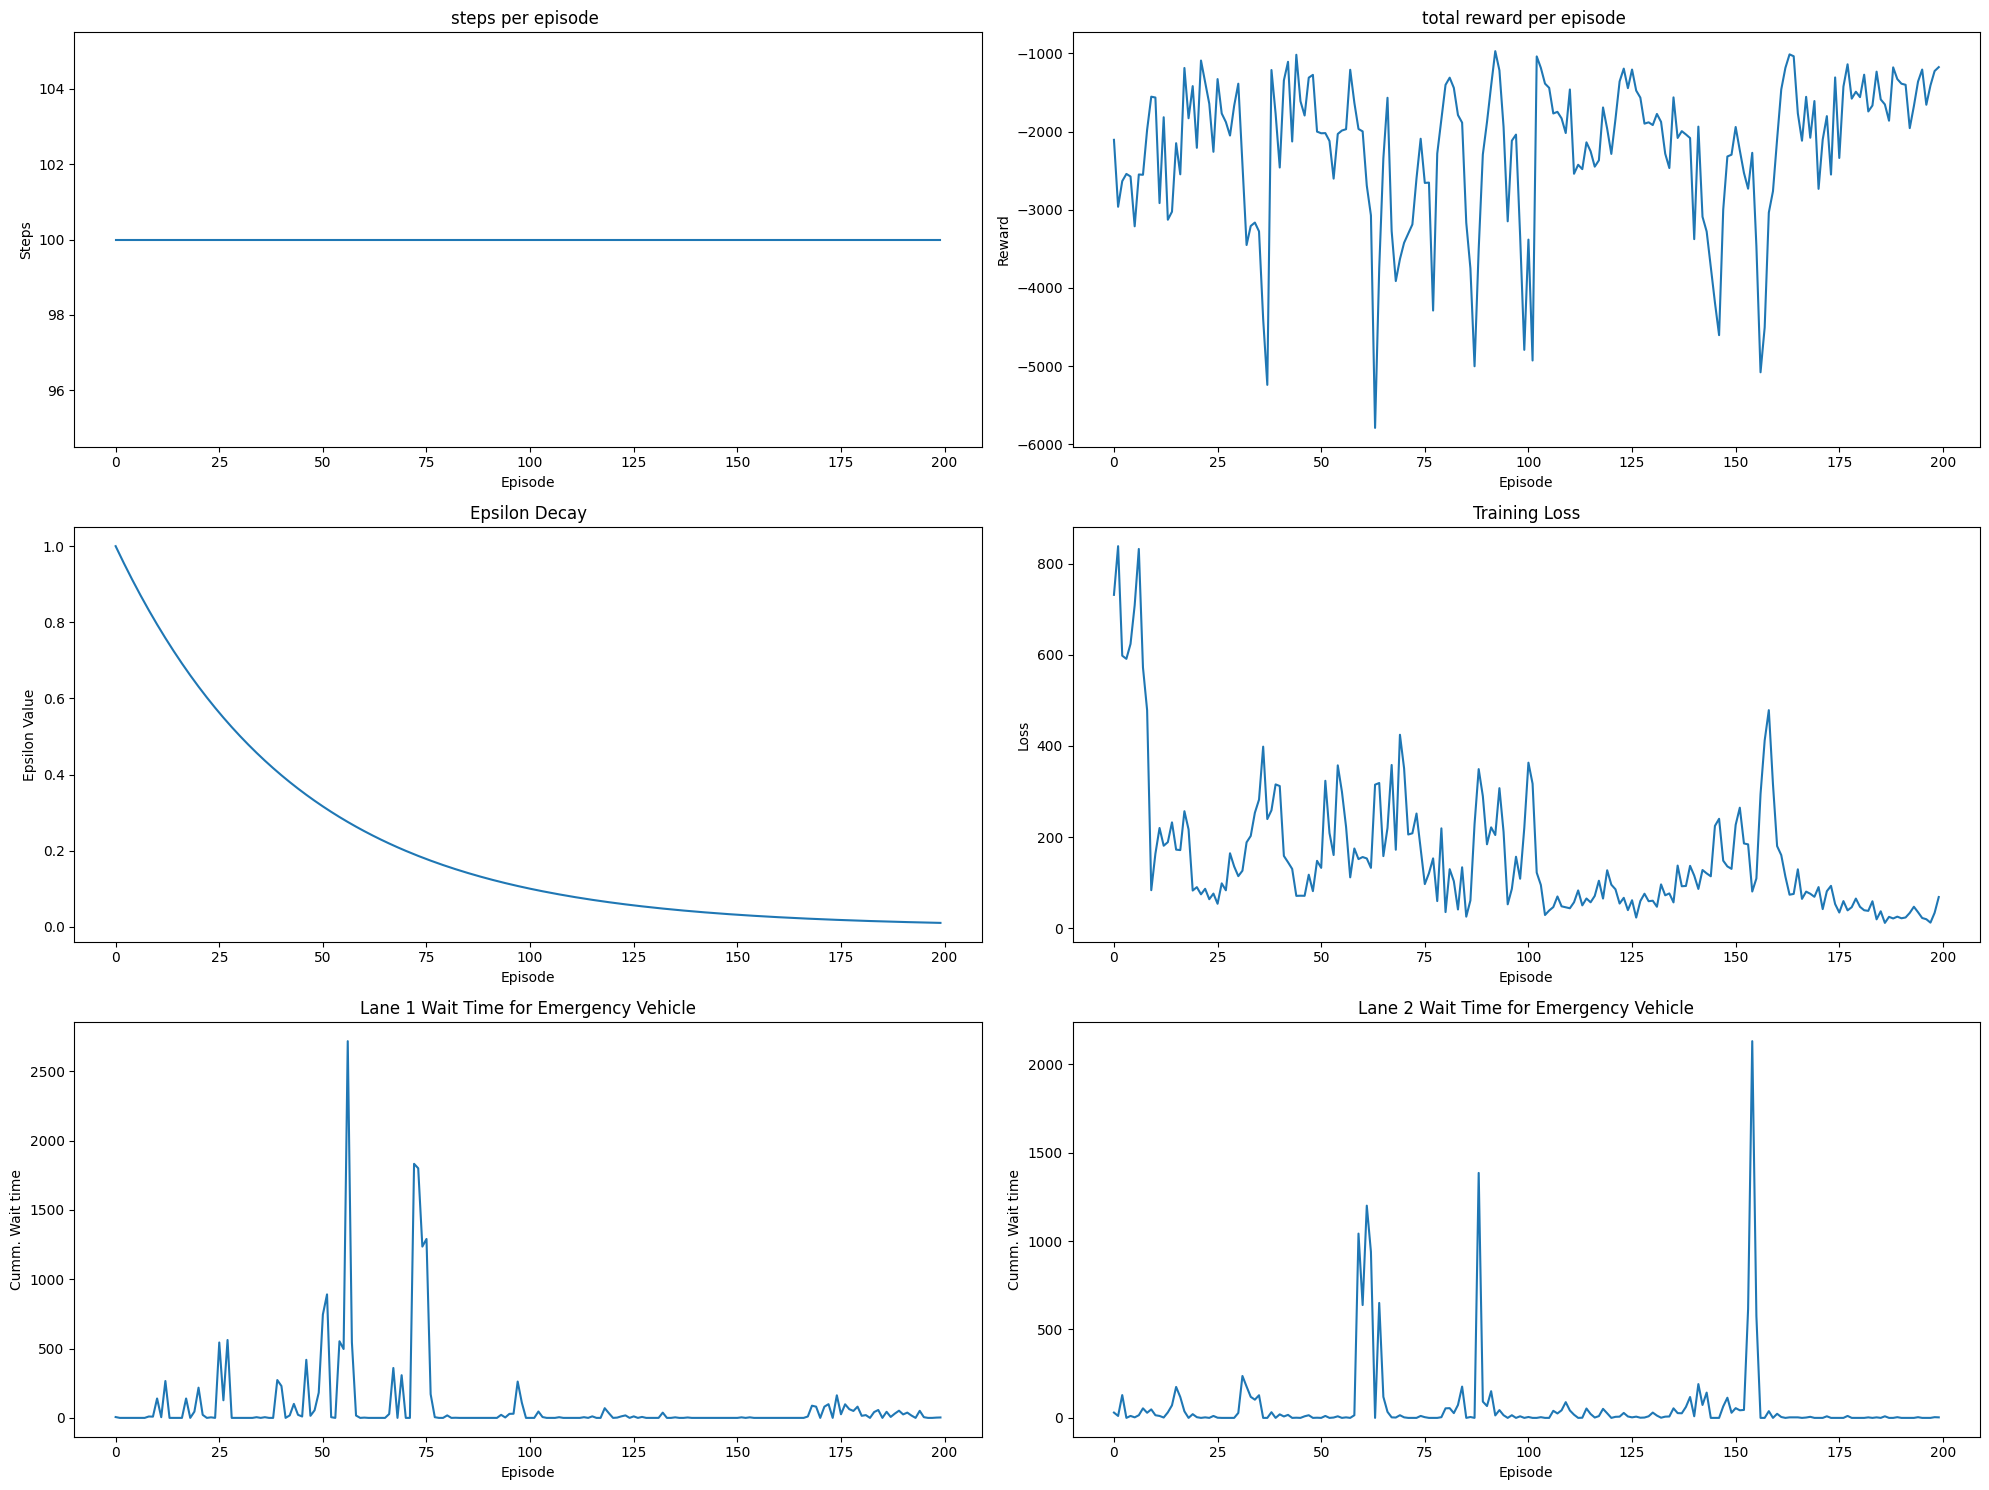

In [8]:
# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(3, 2, figsize=(20, 15))

axs[0, 0].plot(range(episodes), steps_per_episode)
axs[0, 0].set_title("steps per episode ")
axs[0, 0].set_xlabel("Episode")
axs[0, 0].set_ylabel("Steps")

axs[0, 1].plot(range(episodes), reward_per_episode)
axs[0, 1].set_title("total reward per episode ")
axs[0, 1].set_xlabel("Episode")
axs[0, 1].set_ylabel("Reward")

axs[1, 0].plot(range(episodes), epsilon_per_episode)
axs[1, 0].set_title("Epsilon Decay")
axs[1, 0].set_xlabel("Episode")
axs[1, 0].set_ylabel("Epsilon Value")

axs[1, 1].plot(range(len(train_loss)), train_loss)
axs[1, 1].set_title("Training Loss")
axs[1, 1].set_xlabel("Episode")
axs[1, 1].set_ylabel("Loss")

axs[2, 0].plot(range(len(wait_per_episode_lane_1)), wait_per_episode_lane_1)
axs[2, 0].set_title("Lane 1 Wait Time for Emergency Vehicle")
axs[2, 0].set_xlabel("Episode")
axs[2, 0].set_ylabel("Cumm. Wait time")

axs[2, 1].plot(range(len(wait_per_episode_lane_2)), wait_per_episode_lane_2)
axs[2, 1].set_title("Lane 2 Wait Time for Emergency Vehicle")
axs[2, 1].set_xlabel("Episode")
axs[2, 1].set_ylabel("Cumm. Wait time")

plt.tight_layout()
plt.show()

In [9]:
n_episodes = 5
agent.epsilon = 0
reward_per_episode = [0]*n_episodes
wait_per_episode_lane_1 = [0] * n_episodes
wait_per_episode_lane_2 = [0] * n_episodes
for episode in range(n_episodes):
    obs = env.reset()
    done = {"__all__": False}

    # play one episode
    while not done["__all__"]:
        action = agent.step(obs, train=False)
        next_obs, reward, done, info = env.step({'t': action})
        reward_per_episode[episode] += reward['t']
        obs = deepcopy(next_obs)

        if len(info["emergency_waiting_time"]) > 0:
            for k,v in info["emergency_waiting_time"].items():
                if k == "flow_emergency_ns_1":
                    wait_per_episode_lane_1[episode] += v
                elif k == "flow_emergency_ns_2":
                    wait_per_episode_lane_2[episode] += v

 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 372 ACT 25 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 367 ACT 29 BUF 0)                 
 Retrying in 1 seconds


Step #500.00 (1ms ~= 1000.00*RT, ~22000.00UPS, TraCI: 9ms, vehicles TOT 352 ACT 22 BUF 0) 
 Retrying in 1 seconds


Step #500.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 346 ACT 34 BUF 0)                 
 Retrying in 1 seconds


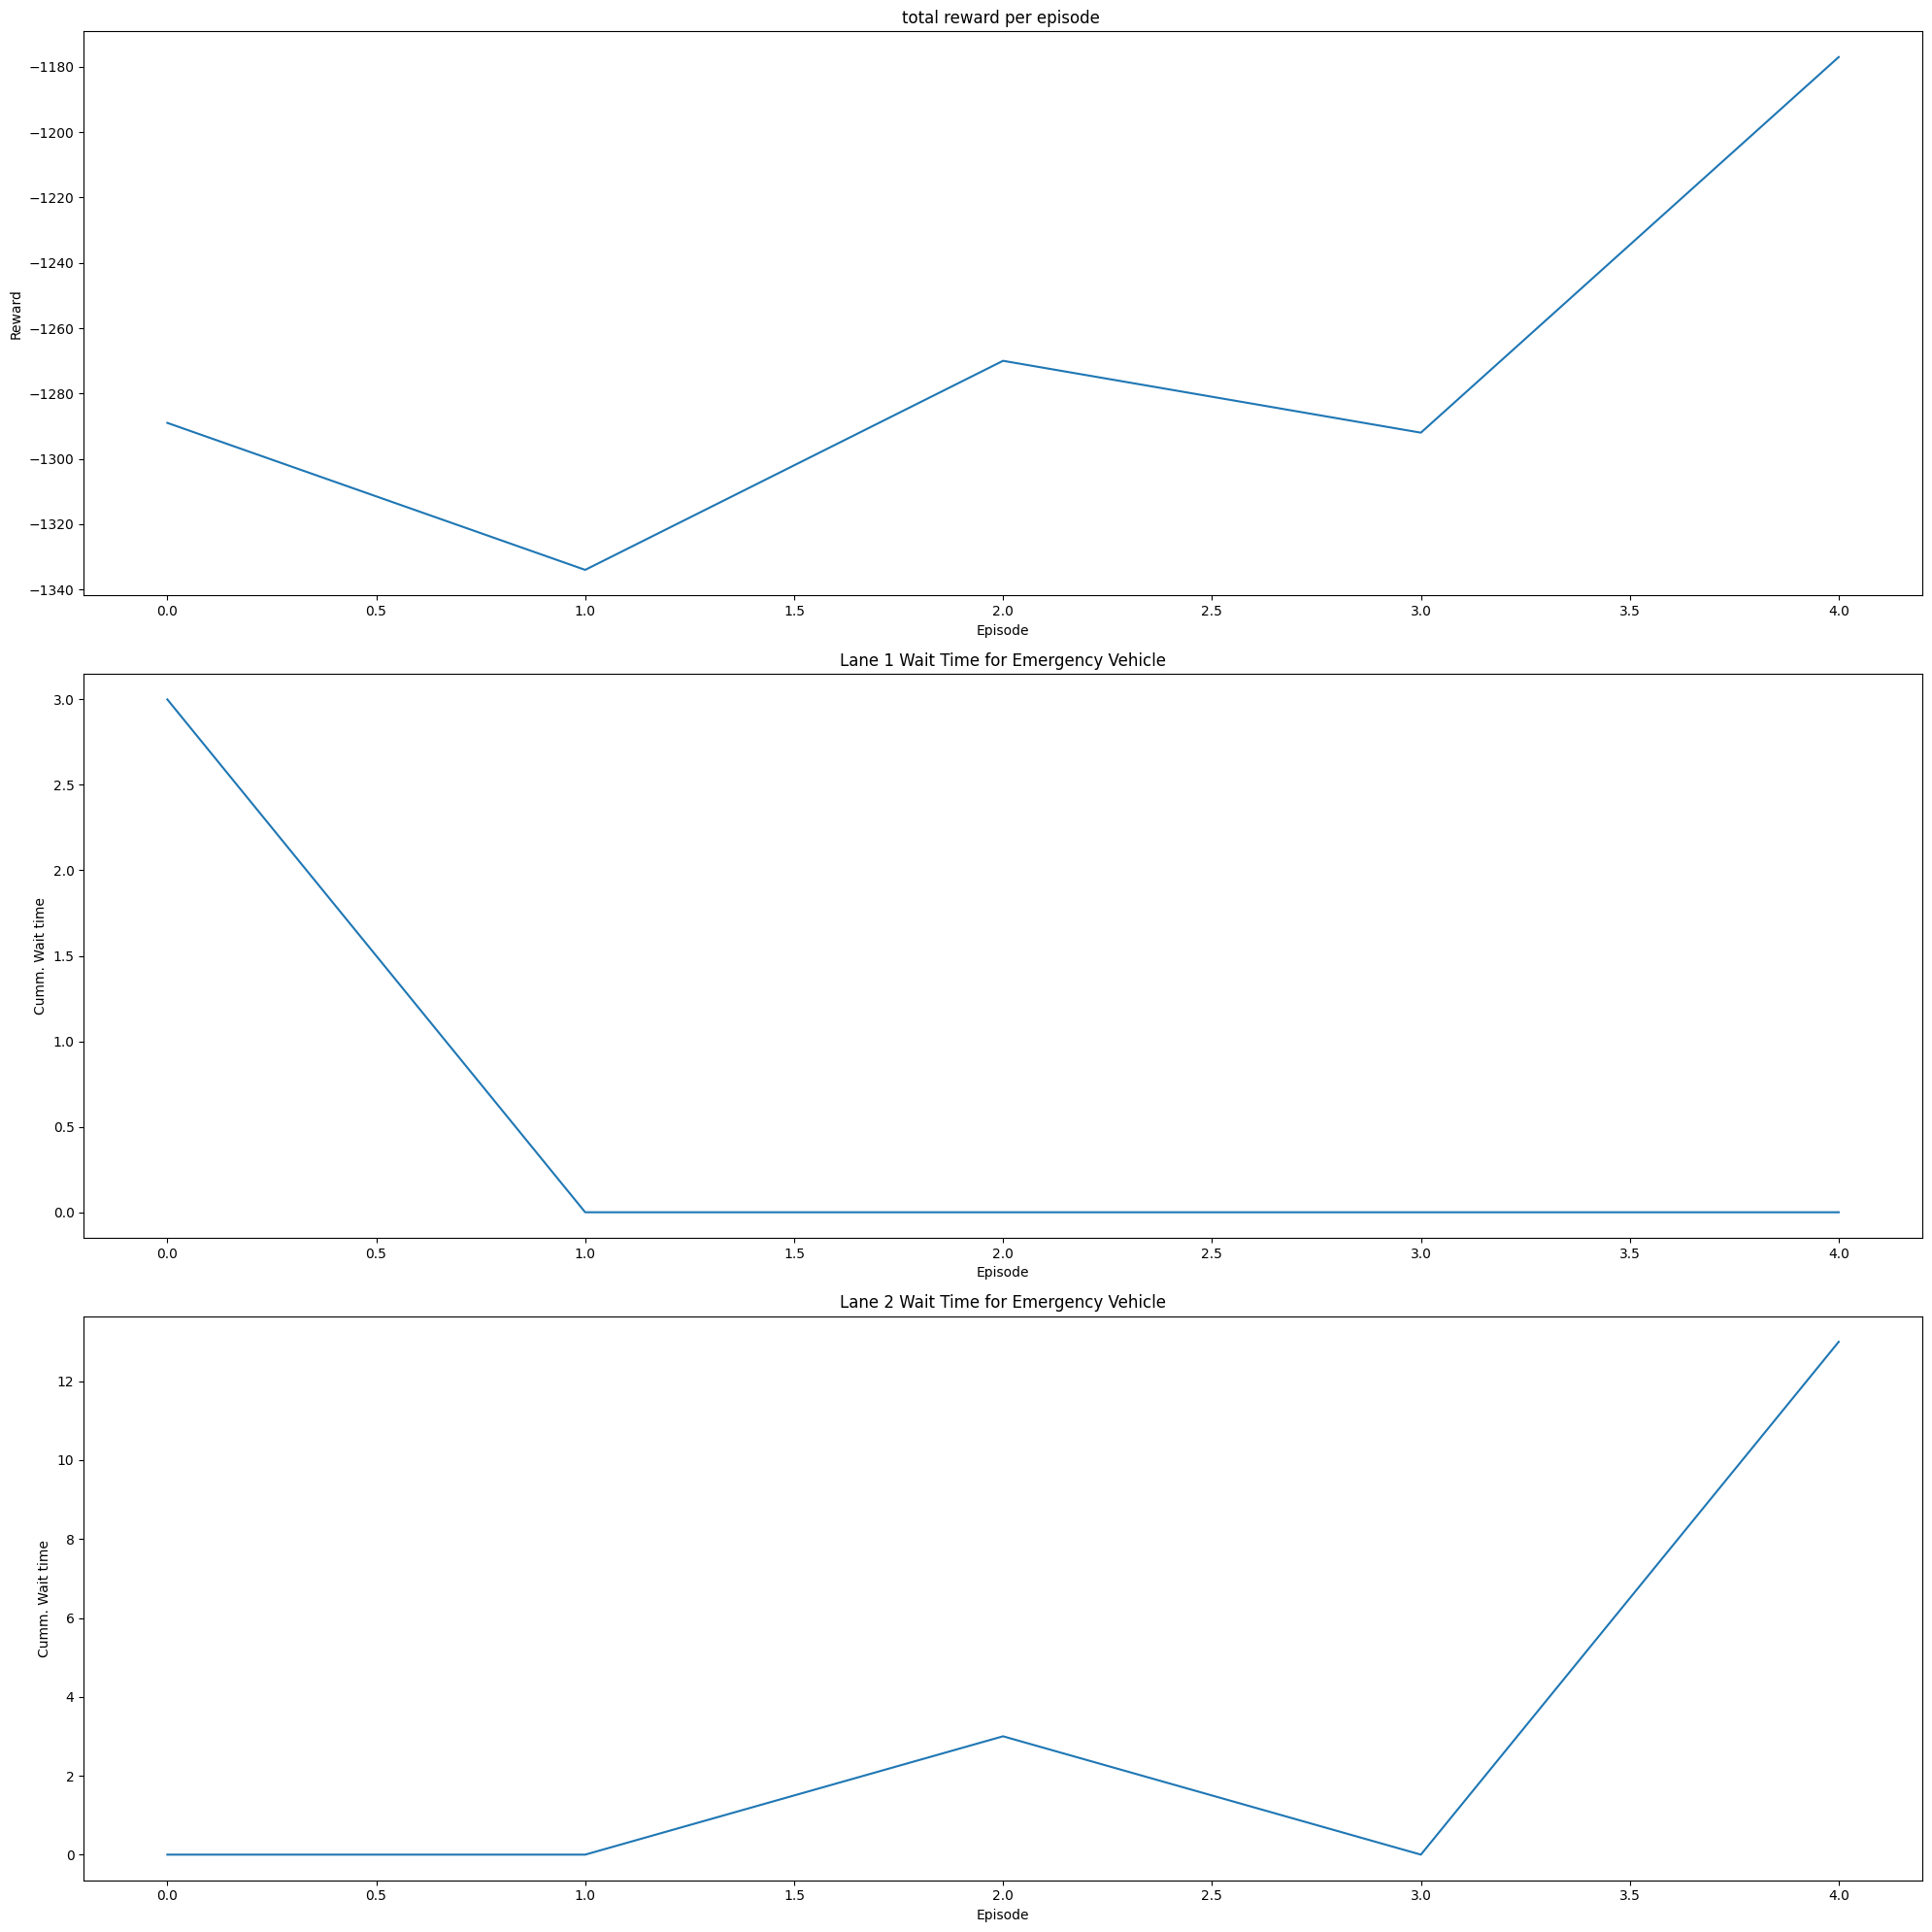

In [10]:
from matplotlib import pyplot as plt
# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(3, 1, figsize=(20, 20))

axs[0].plot(range(n_episodes), reward_per_episode)
axs[0].set_title("total reward per episode ")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(range(len(wait_per_episode_lane_1)), wait_per_episode_lane_1)
axs[1].set_title("Lane 1 Wait Time for Emergency Vehicle")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Cumm. Wait time")

axs[2].plot(range(len(wait_per_episode_lane_2)), wait_per_episode_lane_2)
axs[2].set_title("Lane 2 Wait Time for Emergency Vehicle")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Cumm. Wait time")

plt.tight_layout()
plt.show()

In [11]:
torch.save(model.state_dict(), "emergency_dqn.pth")

In [12]:
import traci

if traci.isLoaded():
    traci.close()

Step #500.00 (0ms ?*RT. ?UPS, TraCI: 208ms, vehicles TOT 350 ACT 19 BUF 0)                


In [13]:
env = SumoEnvironment(
        net_file="single-intersection/single-intersection.net.xml",
        route_file="single-intersection/single-intersection.rou.xml",
        out_csv_name="out_csv",
        use_gui=True,
        num_seconds=5000,
        min_green=5,
        max_green=10,
        observation_class = CustomEmergencyObservationFunction,
        reward_fn = emergency_reward_fn
    )

n_episodes = 1
agent.epsilon = 0
reward_per_episode = [0]*n_episodes

for episode in range(n_episodes):
    obs = env.reset()
    done = {"__all__": False}

    # play one episode
    while not done["__all__"]:
        action = agent.step(obs, train=False)
        next_obs, reward, done, _ = env.step({'t': action})
        reward_per_episode[episode] += reward['t']
        obs = deepcopy(next_obs)

 Retrying in 1 seconds


Step #0.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds


In [14]:
# env = SumoEnvironment(
#         net_file="single-intersection/single-intersection.net.xml",
#         route_file="single-intersection/single-intersection.rou.xml",
#         out_csv_name="out_csv",
#         use_gui=True,
#         num_seconds=500,
#         min_green=5,
#         max_green=10,
#         observation_class = CustomEmergencyObservationFunction,
#         reward_fn = emergency_reward_fn
#     )

# n_episodes = 1
# for episode in range(n_episodes):
#     obs = env.reset()
#     done = {"__all__": False}
#     while not done["__all__"]:
#         next_obs, reward, done, _ = env.step({})